# Binning

This example shows how LiberTEM can be used for fast binning of a large dataset.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import sparse
import matplotlib.pyplot as plt

from libertem.api import Context
from libertem.udf.masks import ApplyMasksUDF

In [3]:
ctx = Context()

## Generate test data
Just a folded linear gradient for illustration

In [4]:
shape = (17, 19, 23, 29)
data = np.linspace(0, 1, np.prod(shape, dtype=np.int64)).reshape(shape)

In [5]:
ds = ctx.load('memory', data=data)

## Define the binning factor and determine target shape

In [6]:
bin_factor = 4

In [7]:
# ceil() to include output bins that only fit partially into the
# source frame
size_y = int(np.ceil(ds.shape.sig[0] / bin_factor))
size_x = int(np.ceil(ds.shape.sig[1] / bin_factor))

## Create a sparse matrix for binning
Each layer corresponds to an output bin. We calculate which pixels are in each output bin.

In [8]:
bin_matrix_layers = []
for y in range(size_y):
    for x in range(size_x):
        layer = np.zeros(ds.shape.sig)
        start_y = y * bin_factor
        stop_y = (y + 1) * bin_factor
        start_x = x * bin_factor
        stop_x = (x + 1) * bin_factor
        layer[start_y:stop_y, start_x:stop_x] = 1
        layer /= np.sum(layer)
        bin_matrix_layers.append(sparse.COO(layer))
bin_matrix = sparse.stack(bin_matrix_layers)

In [9]:
def mask_factory():
    return bin_matrix

## Apply the matrix

In [10]:
udf = ApplyMasksUDF(mask_factories=mask_factory)
result = ctx.run_udf(dataset=ds, udf=udf, progress=True)

Partitions 0/24, Frames:   0%|          | 0/323 [00:00<?, ?it/s]

## Reshape and show result

In [11]:
reshaped_result = result['intensity'].raw_data.reshape(*ds.shape.nav, size_y, size_x)

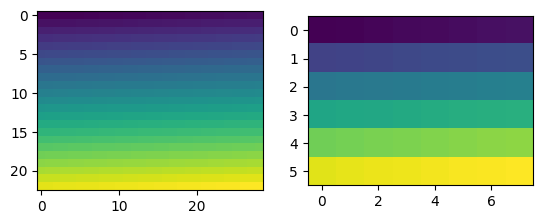

In [12]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data[0, 0])
axes[1].imshow(reshaped_result[0, 0]);